# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

# Universe

In [3]:
WidgetUniverse

In [4]:
# universe and file
#uv_k200 = ['kospi200', 'kospi200_prices_000306_240707.csv']
uv_k200 = ['kospi200', 'kospi200_prices_100104_240707.csv']
uv_krx = ['krx', 'krx_prices.csv']

## KRX

In [5]:
krx = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_krx))
)
krx.upload()

2712 assets from 2019-01-02 to 2024-10-08 uploaded.
df_prices updated


In [6]:
kw = dict(
    n_years=3, 
    close_today = WidgetUniverse.values(1),
    interval=5, pause_duration=1, msg=False
)
#krx.download(**kw) if WidgetUniverse.values(0) else None

In [7]:
df_krx = krx.df_prices
assetnames_krx = krx.get_names()

ERROR from get_names: '164060'


### KOSPI

In [8]:
from pf_utils import KRXDownloader
market = 'KOSPI'
krxd = KRXDownloader(None)
krxd.get_tickers(market)
assets_kospi = krxd.tickers

In [9]:
df_kospi = df_krx[df_krx.columns.intersection(assets_kospi)]

## KOSPI200

In [13]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

200 assets from 2010-01-04 to 2024-07-05 uploaded.
df_prices updated


In [14]:
kw = dict(
    n_years=3, 
    close_today = WidgetUniverse.values(1)
)
k200.download(**kw) if WidgetUniverse.values(0) else None

In [15]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

### Date range

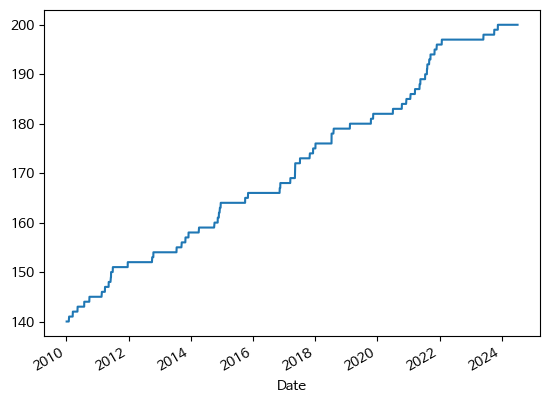

In [15]:
_ = df_k200.unstack().dropna().groupby('Date').count().plot()

In [16]:
start = '2020'
df_k200.loc[start:].dropna(axis=1).columns.size

182

In [17]:
df_k200 = df_k200.loc[start:]

## Financial Ratio

In [16]:
WidgetUniverse

In [17]:
file = 'kospi200_ratios_170531_240930.csv'
fr = FinancialRatios(file, path_data)

Financial ratios of 171 stocks from 2017-05-31 to 2024-09-30 loaded


In [18]:
start = '2023-01-01'
tickers = df_k200.columns.to_list()
kw = dict(
    freq = 'd',
    close_today = WidgetUniverse.values(1)
)
fr.download(tickers, start, **kw) if WidgetUniverse.values(0) else None

In [19]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

PER interpolated from 2017-05-31 to 2024-07-05
PBR interpolated from 2017-05-31 to 2024-07-05


# Backtest

## KOSPI200

In [33]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

16 assets removed for shorter periods (8.0%)
185 assets from 2021-01-04 to 2024-10-18 uploaded.
running self.util_check_days_in_year to check days in a year


In [34]:
lags = dict(lookback=12, lag=5)

In [35]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [36]:
select = 'Momentum'
kwargs_build = dict(
    name=f'K200:{select}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [37]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=f'K200:{select}', select =select,
))
bm.build(**kwargs_build)

In [38]:
select = 'Momentum'
n_assets = 10
kwargs_build = dict(
    name=f'K200:{select}_{n_assets}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=n_assets, **lags
)
bm.build(**kwargs_build)

Backtesting 4 strategies: KODEX200, K200:Momentum, K200:K-ratio, K200:Momentum_10


100%|█████████████████████████████████████████████████████████████████| 4/4 [01:08<00:00, 17.01s/it]

Returning stats


,K200:Momentum,K200:K-ratio,K200:Momentum_10,KODEX200
start,2021-01-03,2021-01-03,2021-01-03,2021-01-03
end,2024-10-18,2024-10-18,2024-10-18,2024-10-18
total_return,5.433096,1.730929,2.219475,-0.05401
cagr,0.634366,0.303606,0.361473,-0.014546
calmar,2.082341,1.434511,1.179317,-0.052294
max_drawdown,-0.304641,-0.211644,-0.30651,-0.278165
avg_drawdown,-0.064854,-0.032253,-0.051486,-0.078234
avg_drawdown_days,18.844444,18.673913,27.40625,166.5
daily_vol,0.397759,0.233239,0.299329,0.157817
daily_sharpe,1.462442,1.280387,1.205438,-0.015753


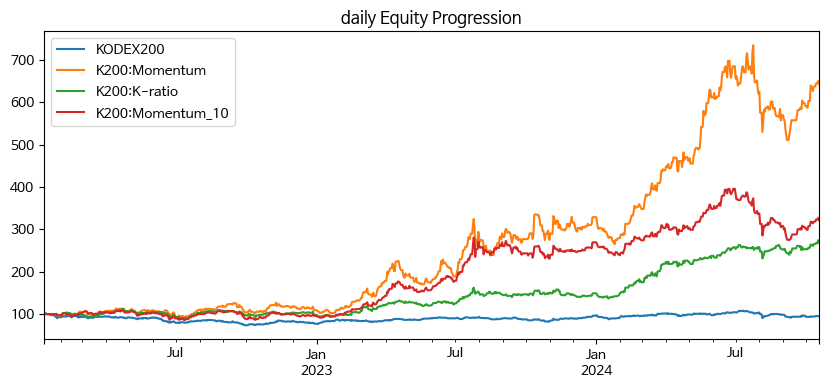

In [39]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [21]:
df_pf = bm.get_historical()
df_pf = df_pf[['KODEX200','K200:Momentum']]

## KRX

### KOSPI + KOSDAQ

In [53]:
n_test = 250
df_train = df_krx.iloc[:-n_test]
df_test = df_krx.iloc[-n_test-250:]

kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_krx
)

In [61]:
bm = BacktestManager(df_train, **kwargs_bm)

2712 assets from 2019-01-02 to 2023-09-22 uploaded.
running self.util_check_days_in_year to check days in a year


In [62]:
lags = dict(lookback=12, lag=20)

In [63]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [20]:
from itertools import product

params = dict(
    p_ast = [5,10,20],
    p_lback = [6,12,18],
    p_lag = [5,10,20],
    p_freq = [20,40,60]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'KRX:a{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
             'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
            #for x in p_comb[:5]]

kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

In [21]:
df_res = bm.run(stats_sort_by='monthly_sharpe', plot=False)
df_res.iloc[:, :5]

Backtesting 82 strategies: KODEX200, KRX:a5/lb6/lg5/f20, ... , KRX:a20/lb18/lg20/f60


100%|███████████████████████████████████████████████████████████████| 82/82 [07:47<00:00,  5.70s/it]


Returning stats


,KRX:a5/lb12/lg20/f40,KRX:a5/lb12/lg10/f40,KRX:a5/lb6/lg5/f40,KRX:a5/lb12/lg5/f40,KODEX200
start,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
end,2023-09-19,2023-09-19,2023-09-19,2023-09-19,2023-09-19
total_return,0.425638,0.292142,0.25555,0.175603,0.201996
cagr,0.078119,0.055868,0.049454,0.034911,0.039796
calmar,0.090731,0.061926,0.058019,0.038897,0.114969
max_drawdown,-0.860995,-0.902183,-0.852383,-0.89751,-0.346143
avg_drawdown,-0.128692,-0.129336,-0.173348,-0.141223,-0.05976
avg_drawdown_days,95.0,88.5,96.2,104.5,70.777778
daily_vol,0.508992,0.530075,0.572377,0.518268,0.18745
daily_sharpe,0.407475,0.370629,0.36839,0.325614,0.305447


In [ ]:
#bm.cross_validate()

2712 assets from 2022-09-23 to 2024-10-08 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200
Backtesting 2 strategies: KODEX200, KRX


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]

Returning stats


,KODEX200,KRX
start,2022-09-22,2022-09-22
end,2024-10-08,2024-10-08
total_return,0.070514,-0.230613
cagr,0.033878,-0.12031
calmar,0.205718,-0.251607
max_drawdown,-0.164682,-0.478165
avg_drawdown,-0.025863,-0.138905
avg_drawdown_days,13.347826,49.833333
daily_vol,0.14441,0.253427
daily_sharpe,0.310743,-0.39444


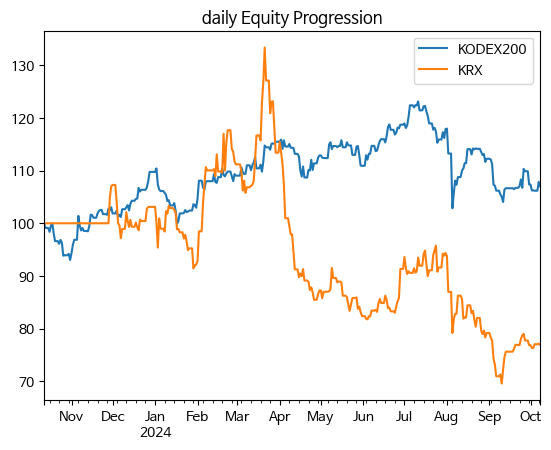

In [64]:
bm = BacktestManager(df_test, **kwargs_bm)

lags = dict(lookback=12, lag=20)
bm.benchmark_ticker(**lags)

kwargs_build = dict(
    name='KRX', select='Momentum', weigh='Equally',
    freq=40, n_assets=5, **lags
)
bm.build(**kwargs_build)
bm.run(stats_sort_by='monthly_sharpe')

### KOSPI

In [65]:
n_test = 250
df_train = df_kospi.iloc[:-n_test]
df_test = df_kospi.iloc[-n_test-250:]

kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_krx
)

In [66]:
bm = BacktestManager(df_train, **kwargs_bm)

938 assets from 2019-01-02 to 2023-09-22 uploaded.
running self.util_check_days_in_year to check days in a year


In [67]:
lags = dict(lookback=12, lag=20)

In [68]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [69]:
from itertools import product

params = dict(
    p_ast = [5,10,20],
    p_lback = [6,12,18],
    p_lag = [5,10,20],
    p_freq = [20,40,60]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'KOSPI:a{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
             'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
            #for x in p_comb[:5]]

kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

In [70]:
df_res = bm.run(stats_sort_by='monthly_sharpe', plot=False)
df_res.iloc[:, :5]

Backtesting 82 strategies: KODEX200, KOSPI:a5/lb6/lg5/f20, ... , KOSPI:a20/lb18/lg20/f60


100%|███████████████████████████████████████████████████████████████| 82/82 [04:04<00:00,  2.98s/it]


Returning stats


,KOSPI:a20/lb12/lg5/f60,KOSPI:a5/lb6/lg10/f40,KOSPI:a10/lb12/lg5/f60,KOSPI:a5/lb12/lg5/f60,KOSPI:a5/lb6/lg10/f20
start,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
end,2023-09-22,2023-09-22,2023-09-22,2023-09-22,2023-09-22
total_return,0.885964,1.326607,0.963691,1.033966,1.071438
cagr,0.143777,0.195775,0.1536,0.16222,0.166721
calmar,0.251753,0.276598,0.213264,0.195233,0.216809
max_drawdown,-0.571101,-0.707797,-0.720234,-0.830907,-0.768978
avg_drawdown,-0.055544,-0.225787,-0.098894,-0.198083,-0.246396
avg_drawdown_days,60.75,131.909091,87.571429,137.777778,164.777778
daily_vol,0.286673,0.574135,0.380673,0.519852,0.569901
daily_sharpe,0.619503,0.600769,0.570333,0.55113,0.556442


In [72]:
df_res = bm.get_stats(sort_by='cagr')
df_res.iloc[:, :5]

,KOSPI:a5/lb6/lg10/f40,KOSPI:a5/lb6/lg10/f20,KOSPI:a5/lb12/lg5/f60,KOSPI:a5/lb6/lg5/f60,KOSPI:a10/lb12/lg5/f60
start,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
end,2023-09-22,2023-09-22,2023-09-22,2023-09-22,2023-09-22
total_return,1.326607,1.071438,1.033966,1.003196,0.963691
cagr,0.195775,0.166721,0.16222,0.158475,0.1536
calmar,0.276598,0.216809,0.195233,0.217719,0.213264
max_drawdown,-0.707797,-0.768978,-0.830907,-0.727886,-0.720234
avg_drawdown,-0.225787,-0.246396,-0.198083,-0.332865,-0.098894
avg_drawdown_days,131.909091,164.777778,137.777778,238.5,87.571429
daily_vol,0.574135,0.569901,0.519852,0.559368,0.380673
daily_sharpe,0.600769,0.556442,0.55113,0.544759,0.570333


In [71]:
bm.portfolios

0) KODEX200
1) KOSPI:a5/lb6/lg5/f20
2) KOSPI:a5/lb6/lg5/f40
3) KOSPI:a5/lb6/lg5/f60
4) KOSPI:a5/lb6/lg10/f20
5) KOSPI:a5/lb6/lg10/f40
6) KOSPI:a5/lb6/lg10/f60
7) KOSPI:a5/lb6/lg20/f20
8) KOSPI:a5/lb6/lg20/f40
9) KOSPI:a5/lb6/lg20/f60
10) KOSPI:a5/lb12/lg5/f20
11) KOSPI:a5/lb12/lg5/f40
12) KOSPI:a5/lb12/lg5/f60
13) KOSPI:a5/lb12/lg10/f20
14) KOSPI:a5/lb12/lg10/f40
15) KOSPI:a5/lb12/lg10/f60
16) KOSPI:a5/lb12/lg20/f20
17) KOSPI:a5/lb12/lg20/f40
18) KOSPI:a5/lb12/lg20/f60
19) KOSPI:a5/lb18/lg5/f20
20) KOSPI:a5/lb18/lg5/f40
21) KOSPI:a5/lb18/lg5/f60
22) KOSPI:a5/lb18/lg10/f20
23) KOSPI:a5/lb18/lg10/f40
24) KOSPI:a5/lb18/lg10/f60
25) KOSPI:a5/lb18/lg20/f20
26) KOSPI:a5/lb18/lg20/f40
27) KOSPI:a5/lb18/lg20/f60
28) KOSPI:a10/lb6/lg5/f20
29) KOSPI:a10/lb6/lg5/f40
30) KOSPI:a10/lb6/lg5/f60
31) KOSPI:a10/lb6/lg10/f20
32) KOSPI:a10/lb6/lg10/f40
33) KOSPI:a10/lb6/lg10/f60
34) KOSPI:a10/lb6/lg20/f20
35) KOSPI:a10/lb6/lg20/f40
36) KOSPI:a10/lb6/lg20/f60
37) KOSPI:a10/lb12/lg5/f20
38) KOSPI:a10/lb12/

In [73]:
pf_list = [0, 66, 5]
bm.get_stats(pf_list, sort_by='cagr')

,KOSPI:a5/lb6/lg10/f40,KOSPI:a20/lb12/lg5/f60,KODEX200
start,2019-01-01,2019-01-01,2019-01-01
end,2023-09-22,2023-09-22,2023-09-22
total_return,1.326607,0.885964,0.176547
cagr,0.195775,0.143777,0.035025
calmar,0.276598,0.251753,0.101186
max_drawdown,-0.707797,-0.571101,-0.346143
avg_drawdown,-0.225787,-0.055544,-0.05976
avg_drawdown_days,131.909091,60.75,70.944444
daily_vol,0.574135,0.286673,0.187398
daily_sharpe,0.600769,0.619503,0.280338


#### Validation

938 assets from 2022-09-23 to 2024-10-08 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200
Backtesting 3 strategies: KODEX200, KOSPI:a20/lb12/lg5/f60, KOSPI:a5/lb6/lg10/f40


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]

Returning stats


,KODEX200,KOSPI:a20/lb12/lg5/f60,KOSPI:a5/lb6/lg10/f40
start,2022-09-22,2022-09-22,2022-09-22
end,2024-10-08,2024-10-08,2024-10-08
total_return,0.076384,-0.109788,-0.452602
cagr,0.036646,-0.055277,-0.255196
calmar,0.22296,-0.188061,-0.365793
max_drawdown,-0.164362,-0.29393,-0.697651
avg_drawdown,-0.026246,-0.073066,-0.13587
avg_drawdown_days,13.73913,33.875,52.666667
daily_vol,0.146027,0.206482,0.432762
daily_sharpe,0.327793,-0.179938,-0.485104


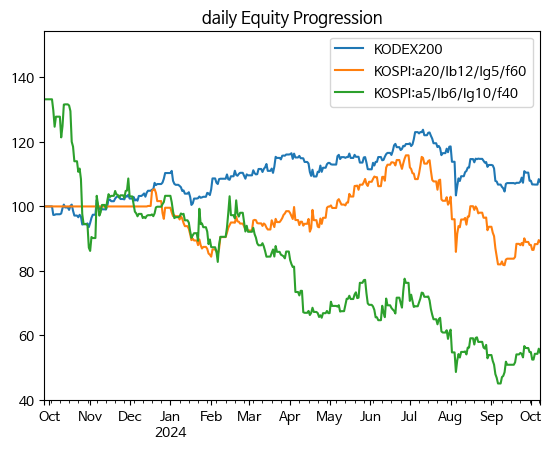

In [74]:
bm = BacktestManager(df_test, **kwargs_bm)

lags = dict(lookback=12, lag=5)
bm.benchmark_ticker(**lags)

kwa_list = [
    {'name':'KOSPI:a20/lb12/lg5/f60', 'n_assets':20, 'lookback':12, 'lag':5, 'freq':60},
    {'name':'KOSPI:a5/lb6/lg10/f40', 'n_assets':5, 'lookback':6, 'lag':10, 'freq':40}
]
kwargs_build = dict(
    select='Momentum', weigh='Equally',
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='monthly_sharpe')

### KOSPI200: Revalidation

In [75]:
n_test = 250
df = df_krx[df_krx.columns.intersection(df_k200.columns)]
df_train = df.iloc[:-n_test]
df_test = df.iloc[-n_test-250:]

In [76]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_krx
)

#### Parameter study

In [83]:
bm = BacktestManager(df_train, **kwargs_bm)

201 assets from 2019-01-02 to 2023-09-22 uploaded.
running self.util_check_days_in_year to check days in a year


In [84]:
from itertools import product

p_args = dict(
    p_ast = [5,10,20],
    p_lback = [6,12,18],
    p_lag = [5,10,20],
    p_freq = [20,40,60]
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'K200:a{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
             'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

In [85]:
df_res = bm.cross_validate(n_sample=20)

Cross-validating 81 strategies: K200:a5/lb6/lg5/f20, K200:a5/lb6/lg5/f40, ... , K200:a20/lb18/lg20/f60


100%|███████████████████████████████████████████████████████████████| 19/19 [00:30<00:00,  1.63s/it]


42.3 mins elapsed, 0.0 secs paused (0.0%)


In [86]:
f = dict(file='param_momentum_k200.csv', path=path_data)
df_cv = bm.get_cat_data(params, **f)

In [ ]:
kw = {'x':'freq', 'row':'n_assets', 'col':'lookback', 'hue':'lag'}

bm.catplot(data=df_cv, y='cagr', height=2.5, aspect=1.1, **kw)

In [34]:
file = 'param_momentum_k200.csv'
df_cv = BacktestManager.catplot(file, path=path_data)

Returning data/param_momentum_k200.csv


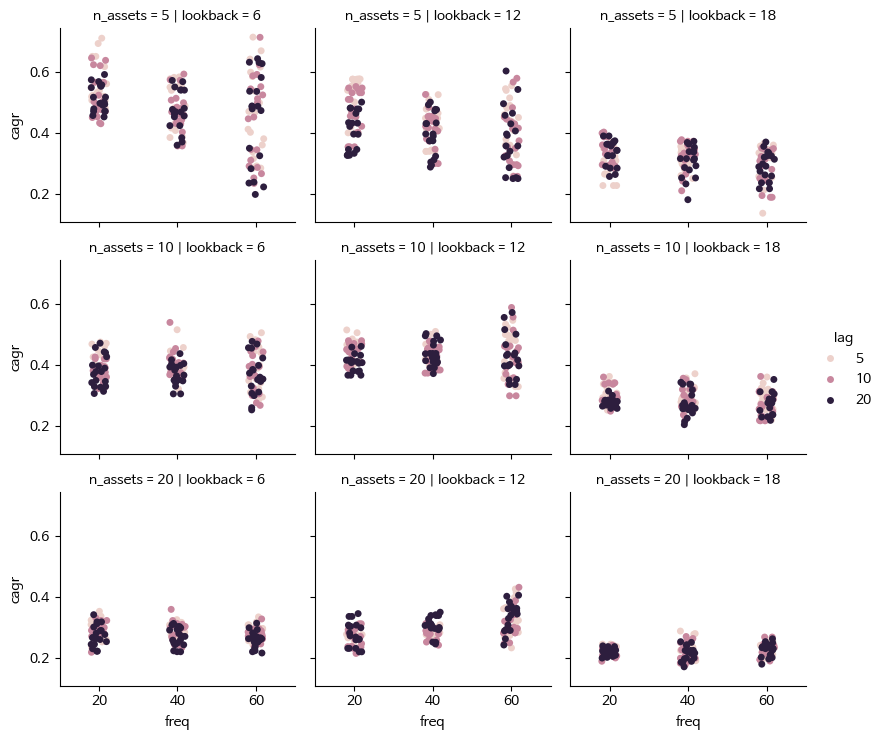

In [37]:
kw = {'x':'freq', 'row':'n_assets', 'col':'lookback', 'hue':'lag'}

_ = BacktestManager.catplot(data=df_cv, y='cagr', height=2.5, aspect=1.1, **kw)

#### Validation

2712 assets from 2022-09-23 to 2024-10-08 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200
Backtesting 4 strategies: KODEX200, K200:a5/lb12/lg20/f20, K200:a10/lb12/lg20/f20, K200:a20/lb12/lg20/f20


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/it]

Returning stats


,K200:a20/lb12/lg20/f20,KODEX200,K200:a10/lb12/lg20/f20,K200:a5/lb12/lg20/f20
start,2022-09-22,2022-09-22,2022-09-22,2022-09-22
end,2024-10-08,2024-10-08,2024-10-08,2024-10-08
total_return,0.243565,0.070514,0.013155,-0.152684
cagr,0.112471,0.033878,0.006411,-0.077816
calmar,0.423257,0.205718,0.022958,-0.219861
max_drawdown,-0.265728,-0.164682,-0.279241,-0.353933
avg_drawdown,-0.089869,-0.025863,-0.16917,-0.101525
avg_drawdown_days,30.8,13.347826,111.333333,47.142857
daily_vol,0.228332,0.14441,0.247337,0.266414
daily_sharpe,0.595759,0.310743,0.150006,-0.179966


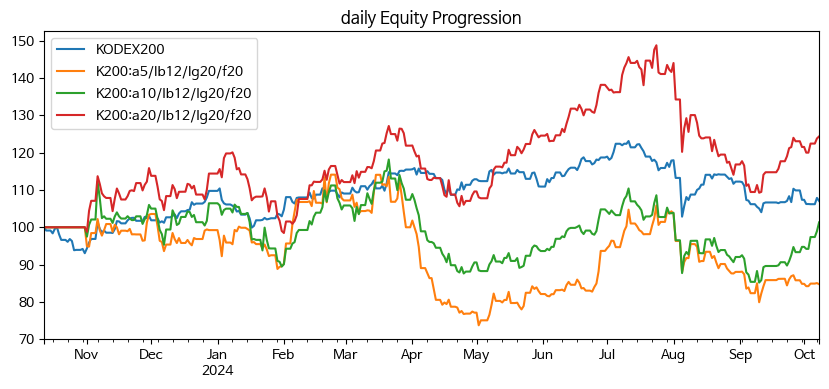

In [55]:
bm = BacktestManager(df_test, **kwargs_bm)

lags = dict(lookback=12, lag=20)
bm.benchmark_ticker(**lags)

kwa_list = [
    #{'name':'K200:a5/lb6/lg5/f20', 'n_assets':5, 'lookback':6, 'lag':5, 'freq':20},
    #{'name':'K200:a20/lb12/lg5/f60', 'n_assets':20, 'lookback':12, 'lag':5, 'freq':60},
    #{'name':'K200:a5/lb12/lg5/f20', 'n_assets':5, 'lookback':12, 'lag':5, 'freq':20},
    {'name':'K200:a5/lb12/lg20/f20', 'n_assets':5, 'lookback':12, 'lag':20, 'freq':20},
    {'name':'K200:a10/lb12/lg20/f20', 'n_assets':10, 'lookback':12, 'lag':20, 'freq':20},
    {'name':'K200:a20/lb12/lg20/f20', 'n_assets':20, 'lookback':12, 'lag':20, 'freq':20},
]

kwargs_build = dict(
    select='Momentum', weigh='Equally', run_cv=False
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))